In [1]:
import numpy as np, pandas as pd, csv, matplotlib.pyplot as plt, os, re, json, seaborn as sns 
from numpy import exp, pi, sinc, sin, tan, convolve, square, abs, arcsin, arctan, sqrt, cos, shape, array, mean,exp 
from collections import defaultdict 
from scipy.optimize import curve_fit 
from sklearn.linear_model import LinearRegression
from typing import List


from concurrent.futures import ThreadPoolExecutor 
import multiprocessing as mp

py_blue = '#1f77b4' 
py_orange = '#ff7f0e' 
py_green = '#2ca02c'

# Diffraction modeling

/tmp/ipykernel_19/2099192541.py:22: RuntimeWarning: invalid value encountered in arcsin
  self.angles = np.arcsin(sin(self.incident_angles)[:, np.newaxis, np.newaxis] - np.outer(self.orders, self.wavelengths)[np.newaxis, :]/self.period)


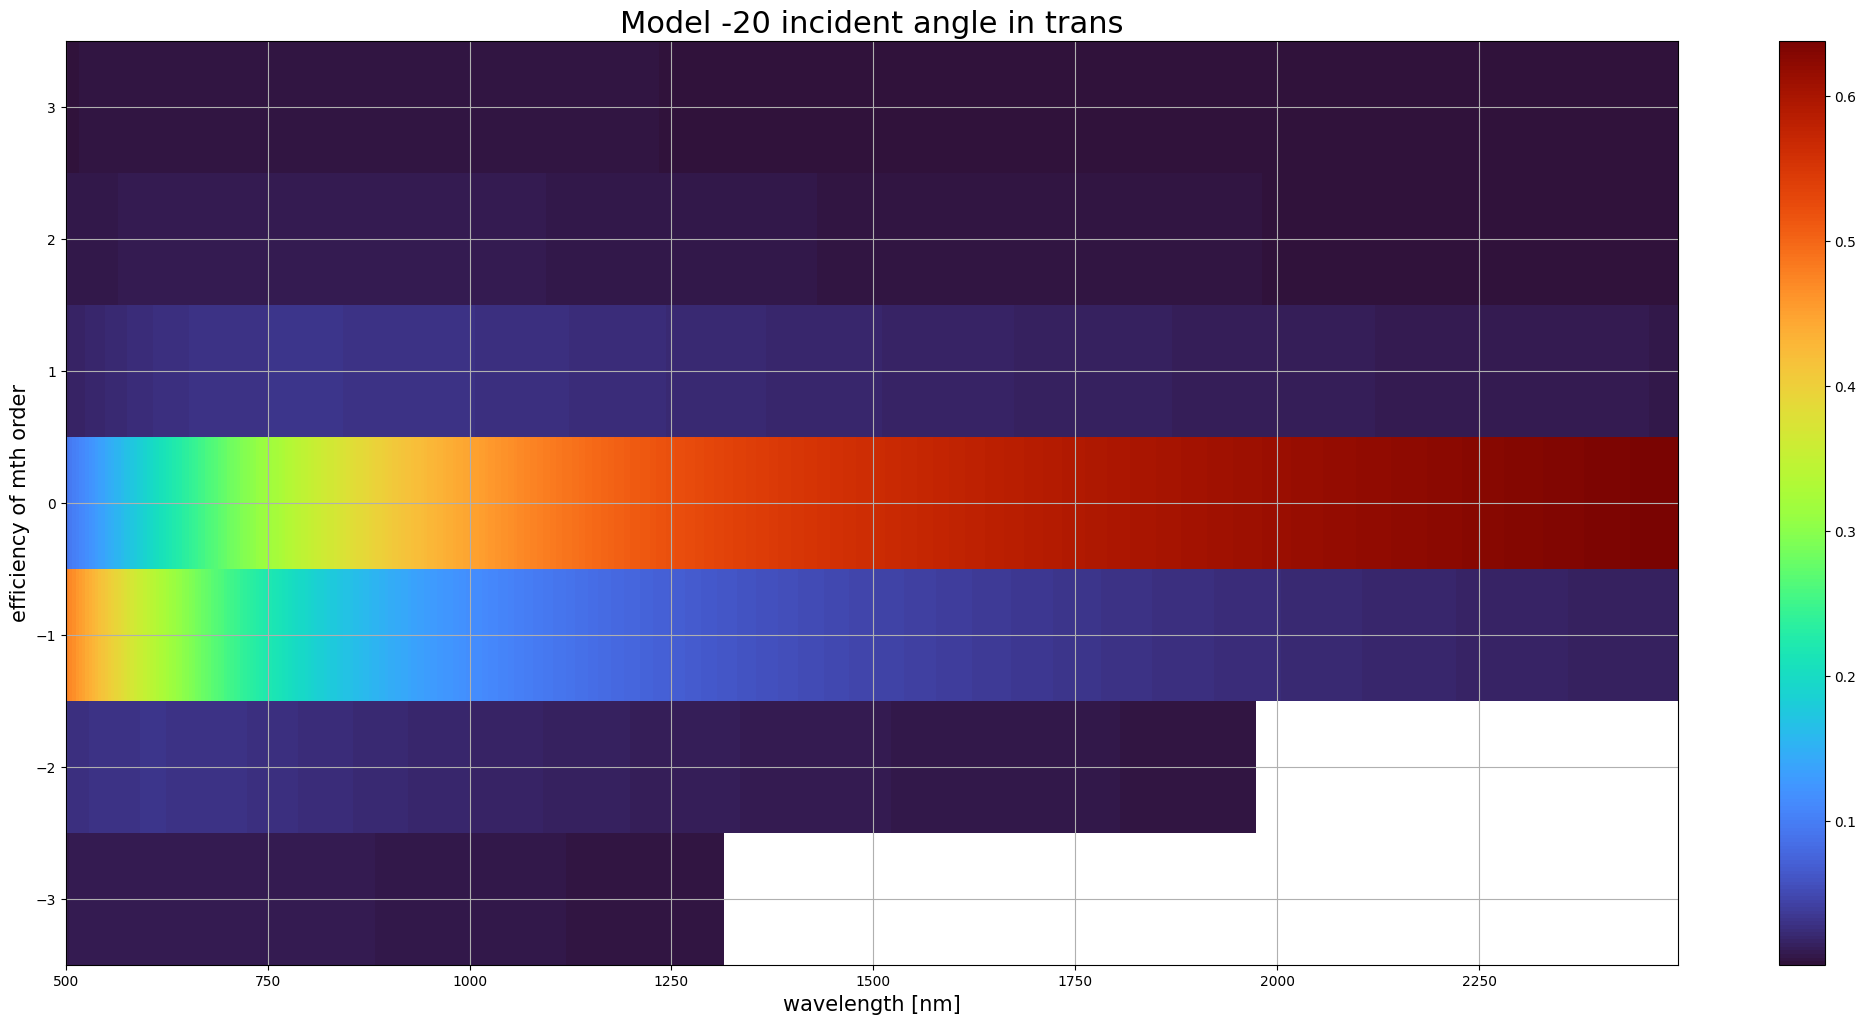

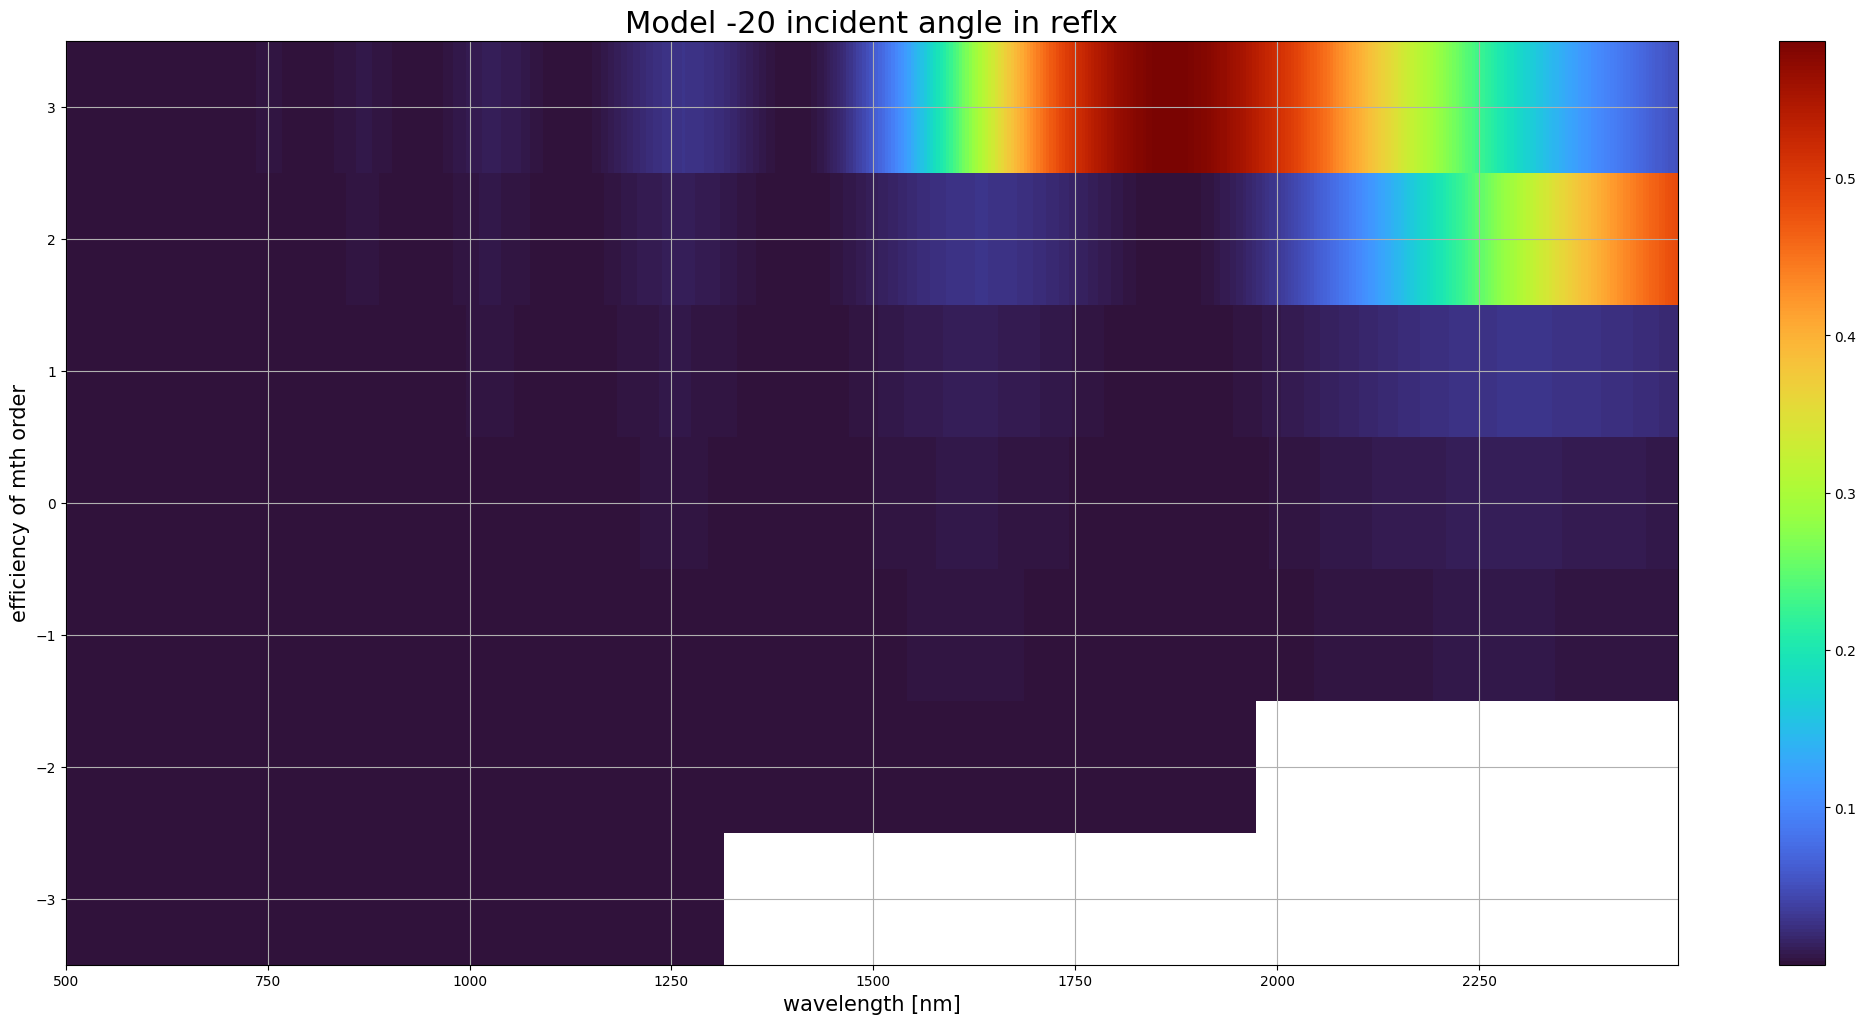

In [2]:
class DiffractionModel:
    """Class for modeling diffraction efficiencies

    Attributes:
        wavelengths (List[int]): list of wavelengths[nm] for which to calculate efficiencies
        orders (List[int]): list of diffraction orders to calculate efficiencies for
        incident_angles (List[int]): list of incident angles for the calculation
        period (int): gratin period in [nm]
    Methods:
        __init__: Initializes the class.
        _reflect: Calculates reflectance efficiencies
        _trans: Calculates transmittance efficiencies
        efficiency_table: returns 2D heatmap of the diffracted efficincies
        plot_envelope: plots envelope curve for the assigned order

    """
    def __init__(self, wavelengths: List[int], orders: List[int], incident_angles: List[int], period: int):
        self.period = period * 1e-9
        self.wavelengths = np.array(wavelengths) * 1e-9
        self.orders = orders
        self.incident_angles = np.array(incident_angles)/180*np.pi
        self.angles = np.arcsin(sin(self.incident_angles)[:, np.newaxis, np.newaxis] - np.outer(self.orders, self.wavelengths)[np.newaxis, :]/self.period)
        self.frequencies = np.sin(self.angles) / self.wavelengths
        self.height = (75*self.period/1e-6 + 300)*1e-9
        self.blaze_angle = np.arctan(self.height/self.period)
        wavelengths_um = self.wavelengths*1e6
        self.n = sqrt(1 + 0.6961663*wavelengths_um**2/(wavelengths_um**2 - 0.0684043**2) + 0.4079426*wavelengths_um**2/(wavelengths_um**2 - 0.1162414**2) + 0.8974794*wavelengths_um**2/(wavelengths_um**2 - 9.896161**2))
        self.reflect_intensity = self._reflect()
        self.trans_intensity = self._trans()

    def _reflect(self):
        """
        Calculates diffraction efficiencies in reflection.

        Returns:
        np.ndarray: Array of diffraction efficiencies in shape of (orders, incident angles, wavelengths).
        """
        tilted_incident_angles = self.incident_angles - self.blaze_angle
        reflx_angles = - 2 * self.blaze_angle - self.incident_angles
        r_coef = (cos(tilted_incident_angles)[:, np.newaxis] - np.outer(cos(reflx_angles), self.n)) / (cos(tilted_incident_angles)[:, np.newaxis] + np.outer(cos(reflx_angles), self.n))
        
        offset = -2* tan(self.blaze_angle) + sin(self.incident_angles)
        offset = np.outer(offset, 1/self.wavelengths)[: , np.newaxis, :]
        intensity = square(abs((r_coef[:, np.newaxis, :]+1)   * sinc((self.frequencies + offset)*self.period)))
        return intensity

    def _trans(self):
        """
        Calculates diffraction efficiencies in transmission.

        Returns:
        np.ndarray: Array of diffraction efficiencies in shape of (orders, incident angles, wavelengths).
        """
        tilted_incident_angles = self.incident_angles - self.blaze_angle
        trans_angles = arcsin(np.outer(tilted_incident_angles, 1/self.n)) - self.blaze_angle
        t_coef = 2*cos(tilted_incident_angles)[:, np.newaxis]  / (np.outer(cos(tilted_incident_angles), self.n) + cos(trans_angles))
        
        offset = ((self.n[np.newaxis, :]-1)*tan(self.blaze_angle) - sin(self.incident_angles)[: , np.newaxis])/self.wavelengths
        offset = offset[:, np.newaxis, :] 
        f_transform = sinc((self.frequencies + offset)*self.period) #* exp(-1j*pi*self.period*(self.frequencies + offset + 2/self.wavelengths*tan(self.blaze_angle)))
        intensity =  square(abs(t_coef[:, np.newaxis, :] * f_transform))
        return intensity
    
    def efficiency_table(self, incident_angle: int, mode: str):
        """
        Plots a heatmap of diffraction efficiencies

        Parameters:
        - incident_angle (int): Angle of incidence for which the diffraction efficiencies should be calculated
        - mode (str):  'trans' or 'reflx'
        """
        if mode not in ['trans', 'reflx']: raise ValueError("Mode must be 'trans' or 'reflx'.")
        indice = np.where(self.incident_angles == np.radians(incident_angle))[0]
        if indice.size == 0: raise ValueError(f"No incident angle matches {incident_angle}.")
        if mode == 'reflx': intensity = np.squeeze(self.reflect_intensity[indice])
        if mode == 'trans': intensity = np.squeeze(self.trans_intensity[indice])
            
        plt.figure(figsize = (26,12))
        plt.imshow(intensity, cmap='turbo', extent = [min(self.wavelengths)*1e9, max(self.wavelengths)*1e9, min(self.orders)-0.5, max(self.orders) + 0.5], aspect = 'auto')
        plt.title('Model '+ str(incident_angle) +' incident angle in '+ mode, size=22)
        plt.xlabel('wavelength [nm]', size = 15)
        plt.ylabel('efficiency of mth order', size = 15)
        plt.grid()
        plt.colorbar()
        #plt.show()

    def plot_envelope(self, order: int, incident_angle: int, mode: str):
        """
        Plots diffraction efficiency curve serving as envelope curve for the measured diffraction peaks

        Parameters:
        - incident_angle (int): Angle of incidence for which the diffraction efficiencies should be calculated
        - order (int): diffraction order for which to calculate
        - mode (str):  'trans' or 'reflx'
        """
        if mode not in ['trans', 'reflx']: raise ValueError("Mode must be 'trans' or 'reflx'.")
        indice = np.where(self.incident_angles == np.radians(incident_angle))[0]
        if indice.size == 0: raise ValueError(f"No incident angle matches {incident_angle}.")
        if mode == 'trans': intensity = np.squeeze(self.trans_intensity[indice])
        if mode == 'reflx': intensity = np.squeeze(self.reflect_intensity[indice])
            
        plt.figure(figsize=(6,1))
        plt.plot(self.wavelengths*1e9, intensity[self.orders.index(order)])
        plt.xlabel('wavelength [nm]')
        plt.ylabel('efficiency')

# example usage
model_efficiency = DiffractionModel(range(500,2500,4), range(-3,4), range(-20,30,10), 6_000)
model_efficiency.efficiency_table(-20,'trans')
model_efficiency.efficiency_table(-20,'reflx')

# Envelope

TODO:
* change zero order filename ( add start and stop )
* add to the report wavelengths+step, orders and inc angles
* get the measurement pictures

In [3]:
class DiffractionDataProcessor():
    """Class for loading scans produced by the sax basic script in CSV format and processing them into diffraction efficiency curves.

    Attributes:
        directory_path (str): Path to directory containing the scans

    Methods:
        __init__: Initializes the class.
        _load_curves: Loading the measured curves and corresponding data to a pandas dataframe
        _process_file: Processing raw csv file for intensity and wavelengths
        _get_measured : Converts individual curves stored in a DataFrame to one single numpy array
        _get_shift: determines how much is the recorded peak spectrally shifted from the expected position
        show_shifts: showing relations of peaks shift to statistically relevant values
        show_diffraction: plotting the obtained diffraction peaks for each order and incident angle
        compare: comparing the modeled efficiency heatmap to the efficiency heatmap measured

    """

    def __init__(self, directory_path: str):
        self.directory = directory_path
        s_files = sorted([file for file in os.listdir(directory_path) if 'S_'in file])
        p_files = sorted([file for file in os.listdir(directory_path) if 'P_'in file])
        files = np.array([s_files, p_files]).transpose()
        with mp.Pool(processes = os.cpu_count()) as pool:
            processed_data = pool.map(self._load_curves, files)
        self.data = pd.DataFrame(processed_data, columns = ['order', 'mode', 'angle', 'incident_angle', 'center', 'shift', 'peak', 'slope', 'start_w', 'stop_w', 'wavelengths', 'intensity'])
        self.incident_angles = sorted(self.data['incident_angle'].unique()) # AUTOMATE
        print('Incident agles: ', self.incident_angles)
        self.orders = sorted(self.data['order'].unique())  # AUTOMATE
        print('Orders: ', self.orders)
        self.wavelengths  = range(500,2500,4)  # AUTOMATE and include the step in the report
        self.measured_trans = self._get_measured('trans')
        self.measured_reflx = self._get_measured('reflx')
        self.model_efficiency = DiffractionModel(self.wavelengths, self.orders, self.incident_angles, 6_000)

    def _load_curves(self, s_p_files: np.ndarray):
        """
        Loads the extracted curves and relevant values to the DataFrame

        Parameters:
        - s_p_files: array of two files, one for each polarisation

        Returns:
        list: list of order, mode, diffraction angle, incidence angle, peak center, peak shift, peak, slope, start_w, stop_w, wavelengths, intensity
        """
        s_file, p_file = s_p_files
        s_intensity, wavelengths = self._process_file(s_file)
        p_intensity, wavelengths = self._process_file(p_file)

        info = s_file.split('_')
        mode, incident_angle, order, dif_angle, curve_range= info[2], int(info[5]), int(info[7]), float(info[10]), info[12].split('-')
        start_w = int(curve_range[0])
        stop_w = int(curve_range[1])
        center = int((start_w + stop_w)/2)
        angle = dif_angle + incident_angle
        if mode == 'trans': 
            angle = 180 + angle if angle < 0  else 180 - angle

        usable = min(len(s_intensity), len(p_intensity), len(wavelengths))
        intensity = (s_intensity[:usable] + p_intensity[:usable])/2
        wavelengths = wavelengths[:usable]
        shift, peak = self._get_shift(wavelengths, intensity)
        slope = cos(dif_angle/180*pi)/order if order != 0 else 1

        return [order, mode, dif_angle, incident_angle, center, shift, peak, slope, start_w, stop_w, wavelengths, intensity]

    def _process_file(self, file_path: str):
        """
        Extracts intensity and wavelengths pairs from provided csv file path to describe the measured curve 

        Parameters:
        - file_path(str): 
        
        Returns:
        - np.array: curve intensities
        - np.array: curve wavelengths
        """
        curve = pd.read_csv(os.path.join(self.directory, file_path), header = 1)
        column = curve.iloc[:, 1]
        sep_index = column[column.isnull()].index[0]
        curve = curve.iloc[:sep_index]
        curve = curve.drop(['Unnamed: 2'], axis = 1)
        wavelengths = pd.to_numeric(curve.iloc[:, 0])
        intensity = pd.to_numeric(curve.iloc[:, 1])
        filtered_wavelengths = np.array([w for w, i in zip(wavelengths, intensity) if w % 4 == 0])
        filtered_intensity = np.array([i for w, i in zip(wavelengths, intensity) if w % 4 == 0])

        return filtered_intensity, filtered_wavelengths
    
    def _get_measured(self, mode: str):
        """
        Loads diffraction intensities from each measurement stored in a DataFrame to a single numpy array

        Parameters:
        - mode(str): 'trans' or 'reflx' to determine which intensities to load 
        
        Returns:
        - np.array: all the measured intensities for a given mode
        """
        measured = np.full([len(self.incident_angles), len(self.orders), len(self.wavelengths)], np.nan)
        for i in self.incident_angles:
            for m in self.orders:
                curve_df = self.data[(self.data['order'] == m) & (self.data['mode'] == mode) & (self.data['incident_angle'] == i)]
                for index, row in curve_df.iterrows():
                    if m == 0:
                        start_index = 0
                        stop_index = int((2500 - min(self.wavelengths))/4)
                        intensity = row['intensity'][:stop_index-start_index]
                        measured[np.where(self.incident_angles == i)[0][0]][np.where(self.orders == m)[0][0]][start_index:stop_index] = intensity[::-1]
                    else:
                        start_index = int((row['start_w'] - min(self.wavelengths))/4)
                        stop_index = int((row['stop_w'] - min(self.wavelengths))/4)
                        measured[np.where(self.incident_angles == i)[0][0]][np.where(self.orders == m)[0][0]][start_index:stop_index] = row['intensity'][:stop_index-start_index]
        return measured

    def _get_shift(self, wavelengths: list, intensity: list):
        """
        Calculates how much is the peak maxima shifted from the center of the measurement

        Parameters:
        - wavelengths (list): list of measured wavelengths
        - intensity (list): list of measured intensities
        
        Returns:
        - float: shift
        - float: peak maxima
        """
        bounds = ((-np.inf, -np.inf, -np.inf), (0, np.inf, np.inf))
        p0 = [-1, 1, 1]
        params, params_covariance = curve_fit(self._parabola, wavelengths, intensity, bounds = bounds, p0 = p0)
        y_pred = self._parabola(wavelengths, *params)
        peak_max = wavelengths[np.argmax(y_pred)]
        center = (max(wavelengths) + min(wavelengths))/2
        shift = center - peak_max
        return shift, max(y_pred)

    def _parabola(self, x, a, b, c):
        return a* x**2 + b * x + c

    def show_shifts(self):
        """
        Displays the dependence between the size of shift with the selected variable stored in the DataFrame
        """
        for m in self.orders:
            if m == 0 : continue
            reflx_df = self.data[(self.data['mode'] == 'reflx') & (self.data['order'] == m)]
            plt.scatter(reflx_df['slope'], reflx_df['shift'], color = py_blue, label = 'reflx')
        plt.title('Reflex comparison')
        plt.show()
        
        for m in self.orders:
            if m == 0: continue
            trans_df = self.data[(self.data['mode'] == 'trans') & (self.data['order'] ==  m) & (self.data['incident_angle'] ==  0)]
            plt.scatter(trans_df['angle'], trans_df['shift'], label = str(m))#, color = py_orange, label = 'trans')
        plt.legend()
        plt.title('Trans comparison')
        plt.show()
        
        for m in self.orders:
            if m == 0: continue
            trans_df = self.data[(self.data['mode'] == 'trans') & (self.data['order'] ==  m) & (self.data['incident_angle'] ==  20)]
            plt.scatter(trans_df['angle'], trans_df['shift'], label = str(m))#, color = py_orange, label = 'trans')
        plt.legend()
        plt.title('Trans comparison')
        plt.show()
        
        for m in self.orders:
            if m == 0: continue
            trans_df = self.data[(self.data['mode'] == 'trans') & (self.data['order'] ==  m)]
            plt.scatter(trans_df['angle'], trans_df['shift'], label = str(m))#, color = py_orange, label = 'trans')
        plt.legend()
        plt.title('Trans comparison')
        plt.show()

        
        model = LinearRegression(fit_intercept=False)
        x_values = np.array(self.data['slope']).reshape(-1, 1)
        model.fit(x_values, self.data['shift'])
        y_pred = model.predict(x_values)
        plt.plot(x_values, y_pred, color='red', label='Fitted line')
        print(model.intercept_)
        plt.show()
        
    def show_diffraction(self, orders: list=None, incident_angles: list=None, mode: list=None):
        """
        Displays the diffraction measurements for each selcted order and angles of incidence

        Parameters:
        - orders(list): determines measurements of which order will be shown
        - incident_angles(list):  determines angles of incidence for which measurements will be shown
        - mode(list): determines whether to show measurements for transmission, reflection or both
        """
        orders = orders or self.orders
        incident_angles = incident_angles or self.incident_angles
        trans_reflx = mode or ['trans', 'reflx']
        for i in incident_angles:
            for m in orders:
                for mode in trans_reflx:
                    df = self.data[(self.data['mode'] == mode) & (self.data['order'] ==  m) & (self.data['incident_angle'] ==  i)]
                    plt.figure(figsize = (30,6))
                    for index, row in df.iterrows():
                        plt.plot(row['wavelengths'], row['intensity'], label = str(m))
                    plt.title(str(m) + '   ' +str(i)+ '   ' + mode)
                    plt.show()
        
    def compare(self, incident_angle: int, mode: str):
        """
        Displays the measured diffraction efficiencies alongside the modeled ones in two separate heatmaps for the angles of incidence and modes provided.

        Parameters:
        - incident_angle(int): determines angles of incidence for which measurements will be shown
        - mode(str): determines whether to show measurements for transmission, reflection or both
        """
        if mode not in ['trans', 'reflx']: raise ValueError("Mode must be 'trans' or 'reflx'.")
        index = np.where(np.array(self.incident_angles) == incident_angle)[0]
        if index.size == 0: raise ValueError(f"No incident angle matches {incident_angle}.")
        if mode == 'reflx': intensity = np.squeeze(self.measured_reflx[index])
        if mode == 'trans': intensity = np.squeeze(self.measured_trans[index])
        self.model_efficiency.efficiency_table(incident_angle, 'trans')
        plt.figure(figsize = (26,12))
        plt.imshow(intensity[::-1], cmap='turbo', extent = [min(self.wavelengths),max(self.wavelengths),  min(self.orders)-0.5, max(self.orders) + 0.5], aspect = 'auto')#, vmin=0, vmax=1)
        plt.title('Measurement '+ str(incident_angle) +' incident angle in '+ mode, size=22)
        plt.xlabel('wavelength [nm]', size = 15)
        plt.ylabel('efficiency of mth order', size = 15)
        plt.grid()
        plt.colorbar()
        plt.tight_layout()

        # Save the figure
        plt.savefig('comparison.png')

my_processor = DiffractionDataProcessor('/kaggle/input/24-eros/12_13')

Incident agles:  [-20, -10]
Orders:  [-3, -2, -1, 0, 1, 2, 3]


/tmp/ipykernel_19/2099192541.py:22: RuntimeWarning: invalid value encountered in arcsin
  self.angles = np.arcsin(sin(self.incident_angles)[:, np.newaxis, np.newaxis] - np.outer(self.orders, self.wavelengths)[np.newaxis, :]/self.period)


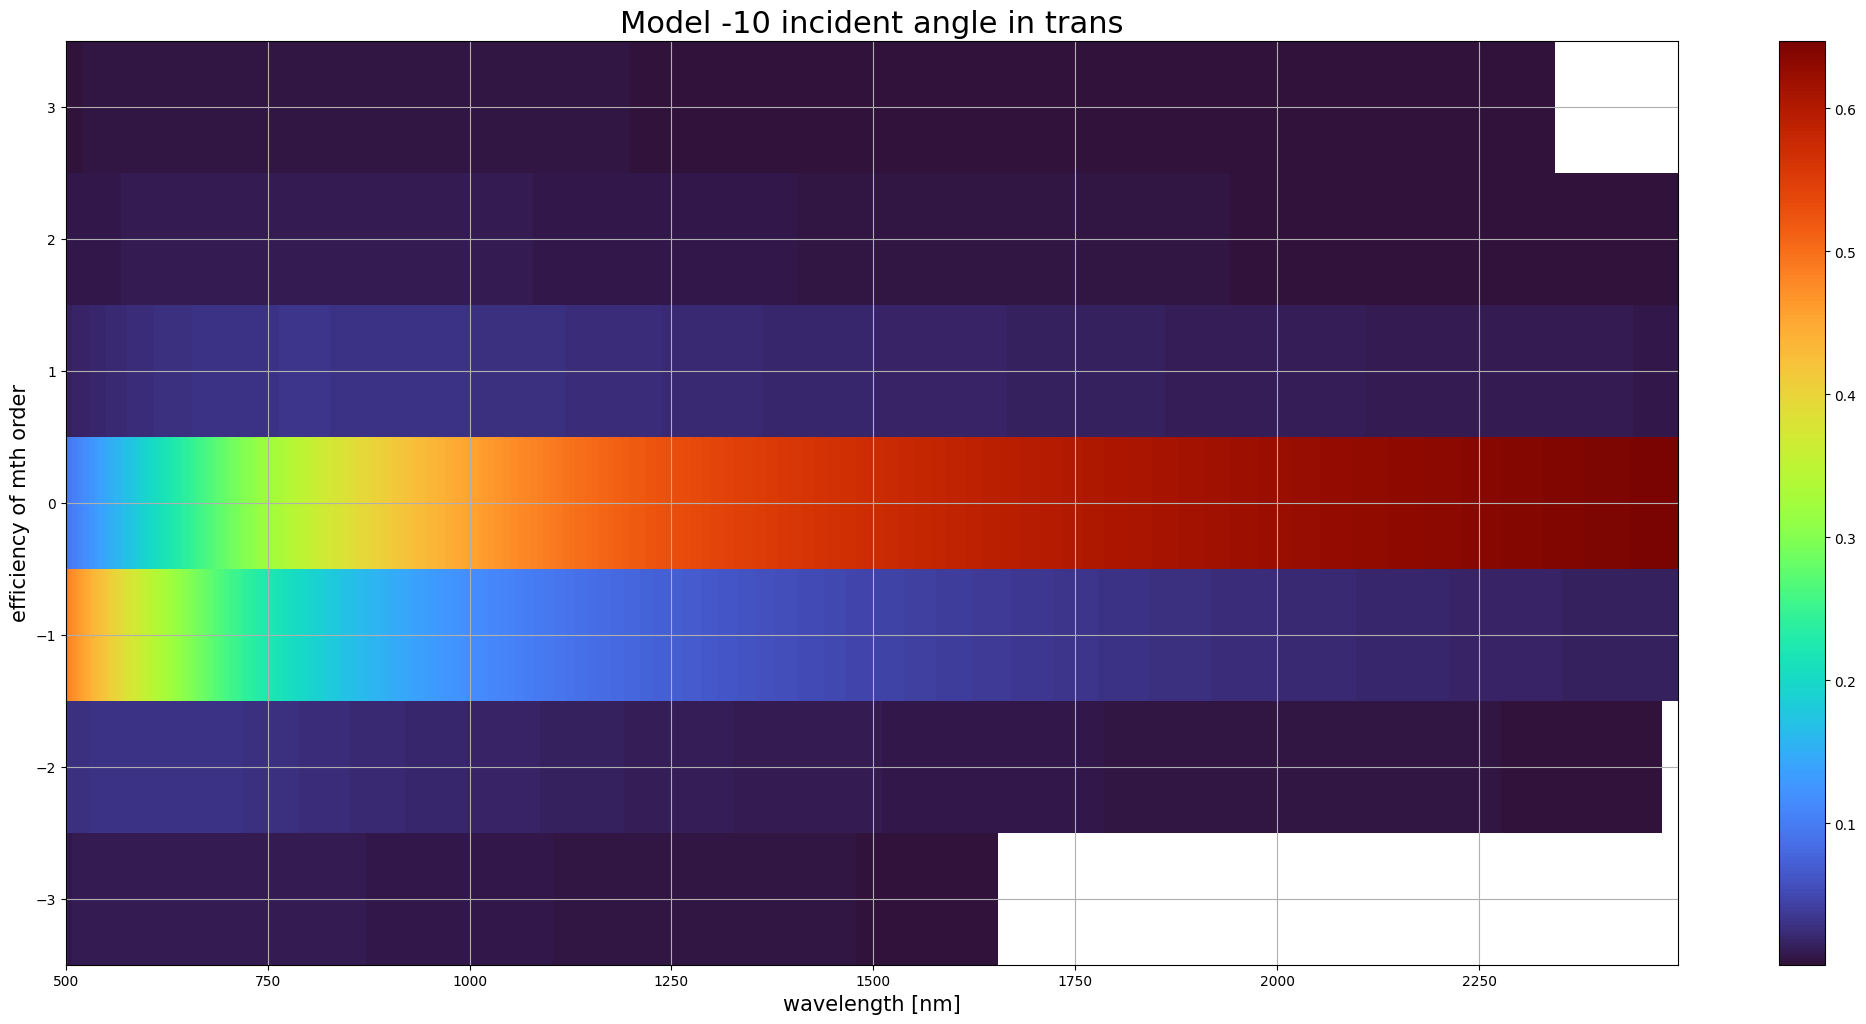

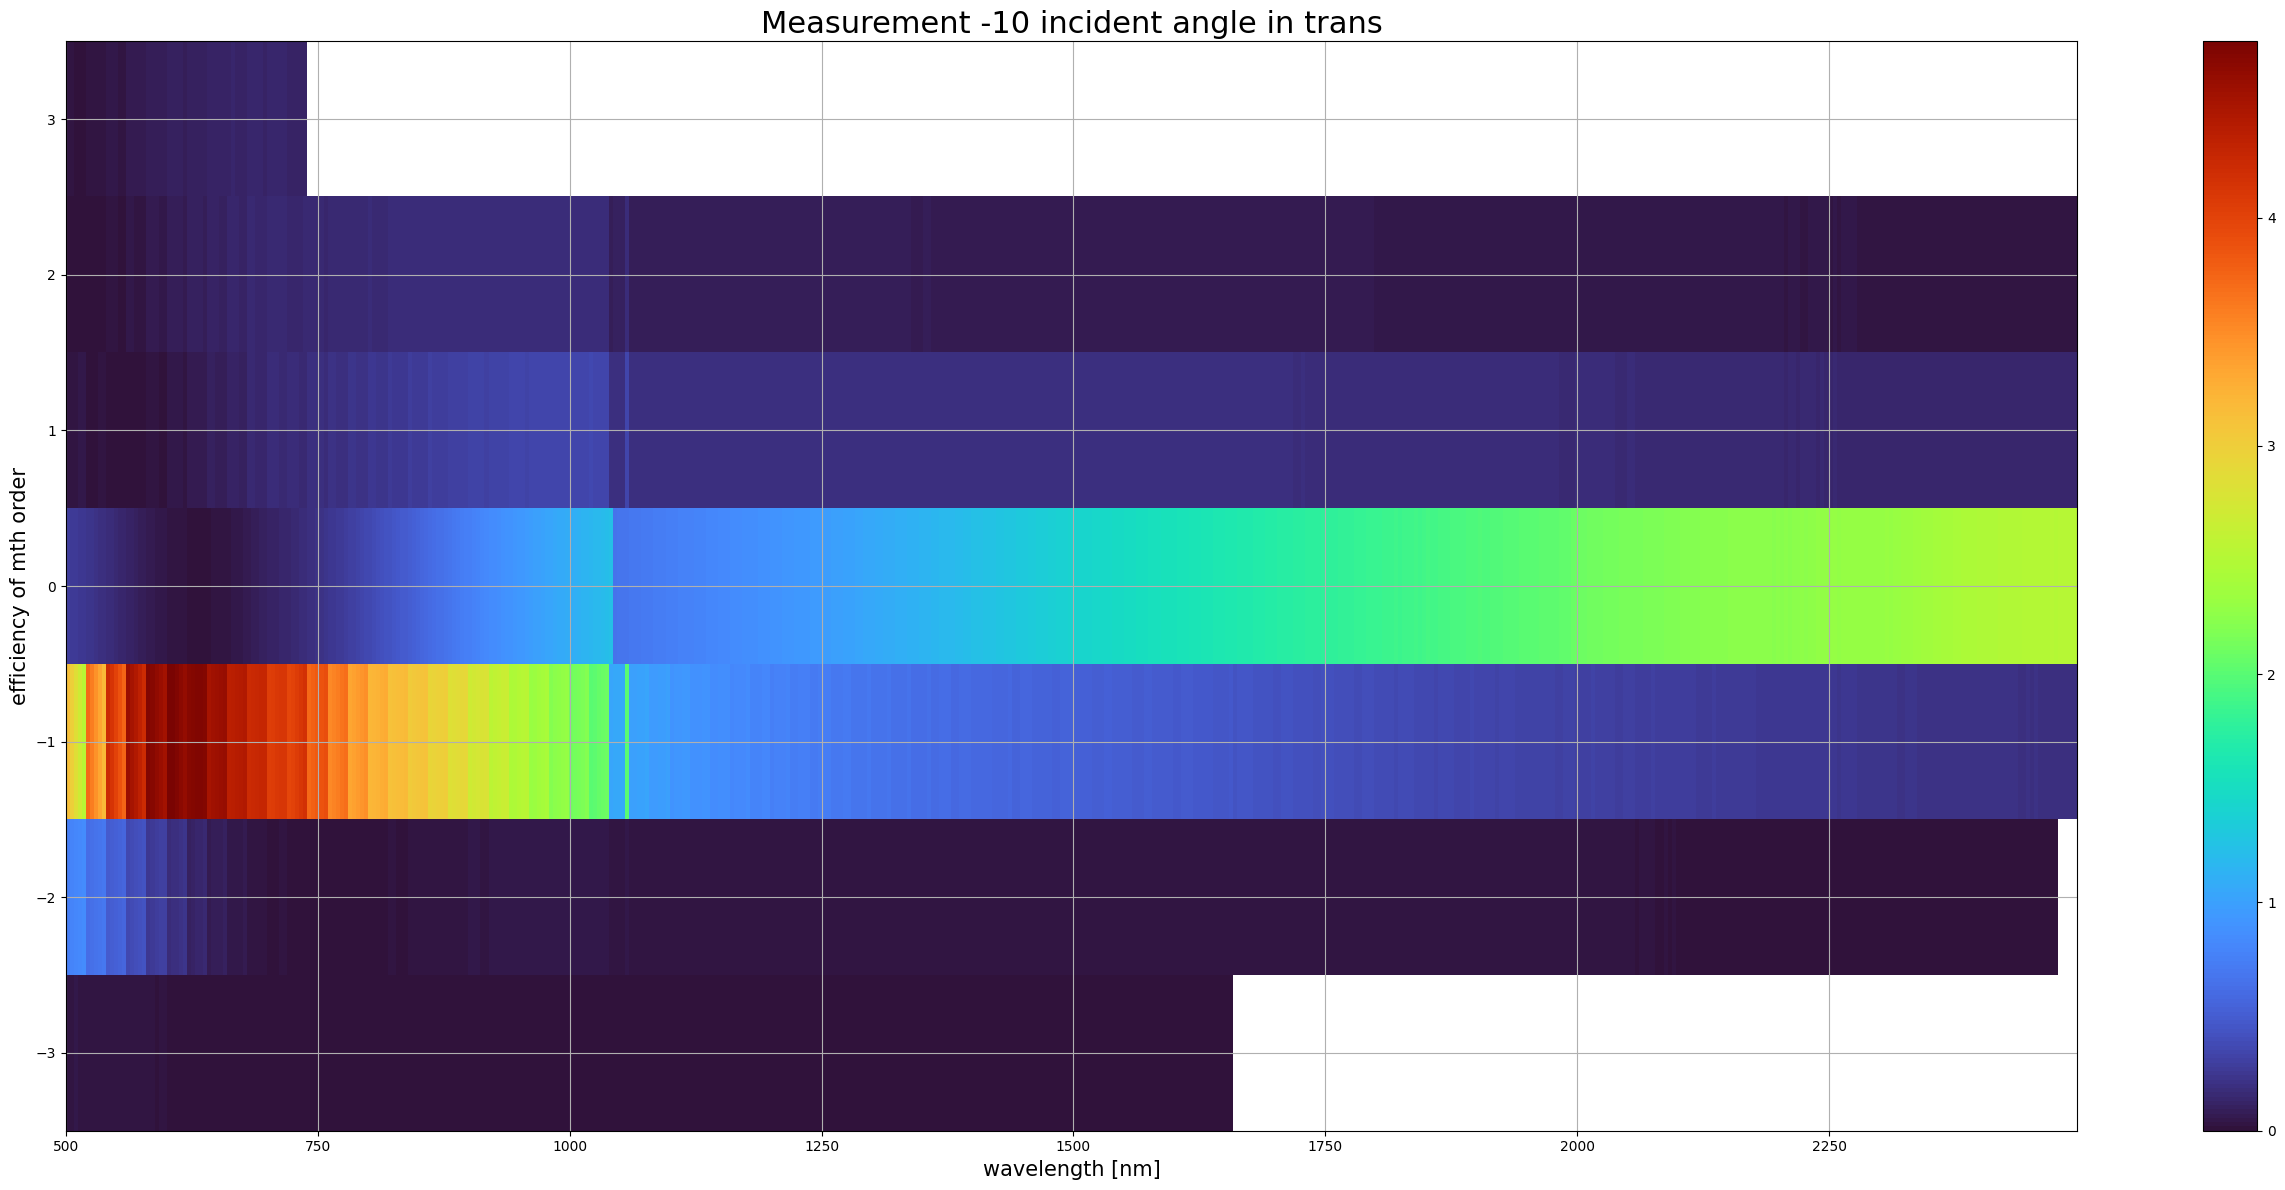

In [4]:
my_processor.compare(-10, 'trans')

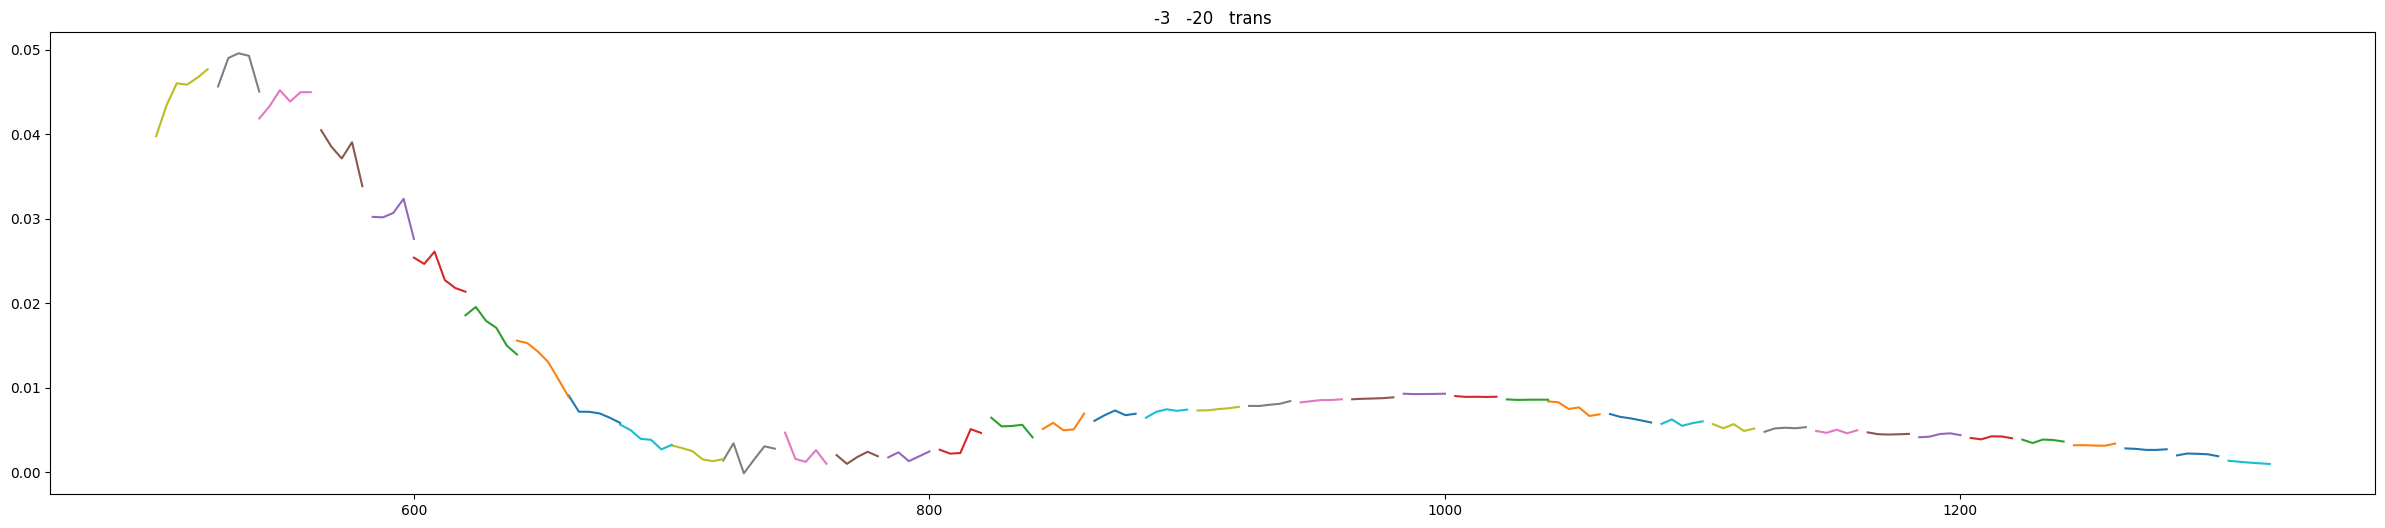

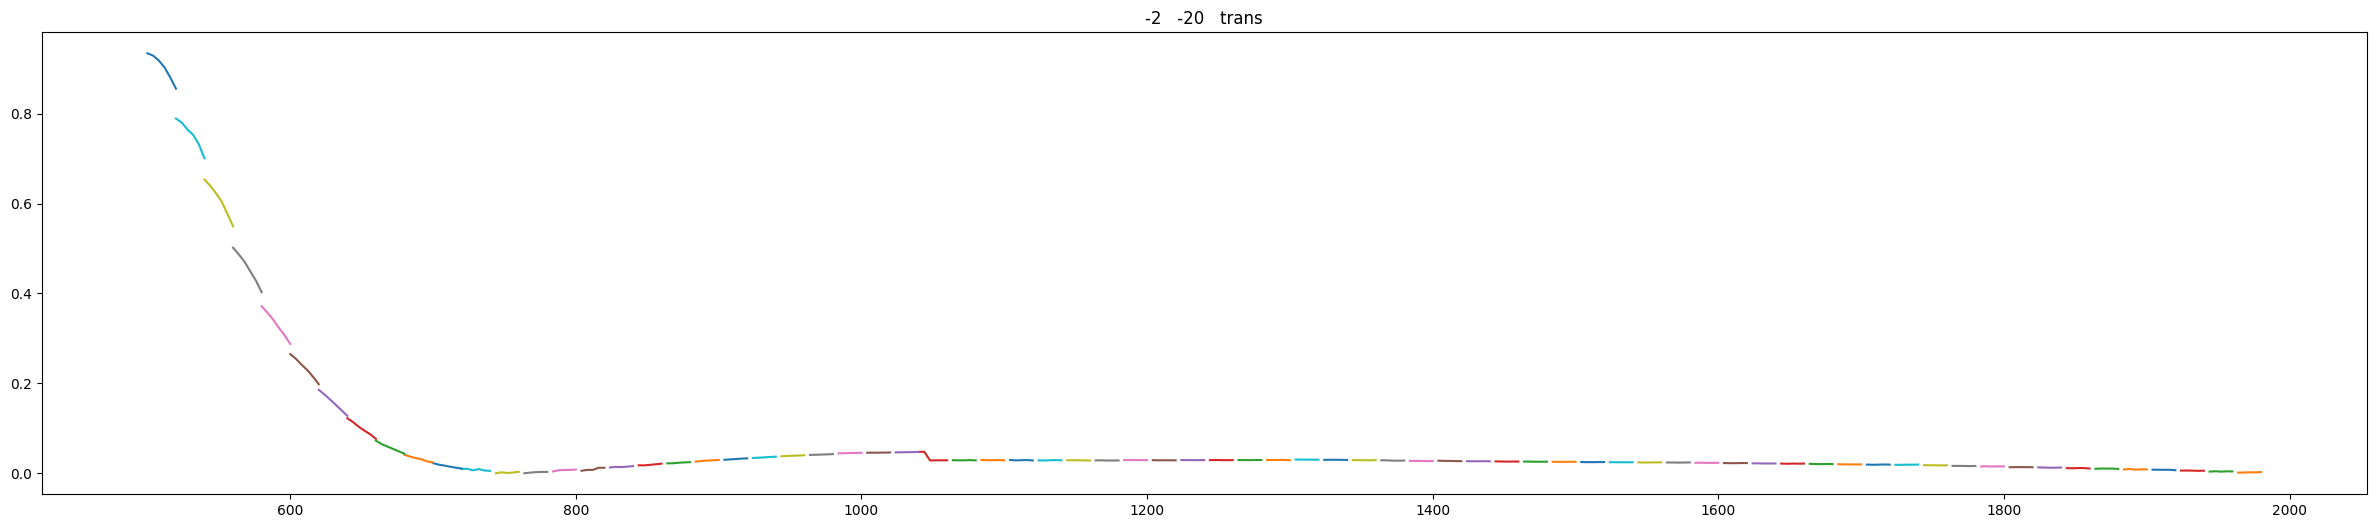

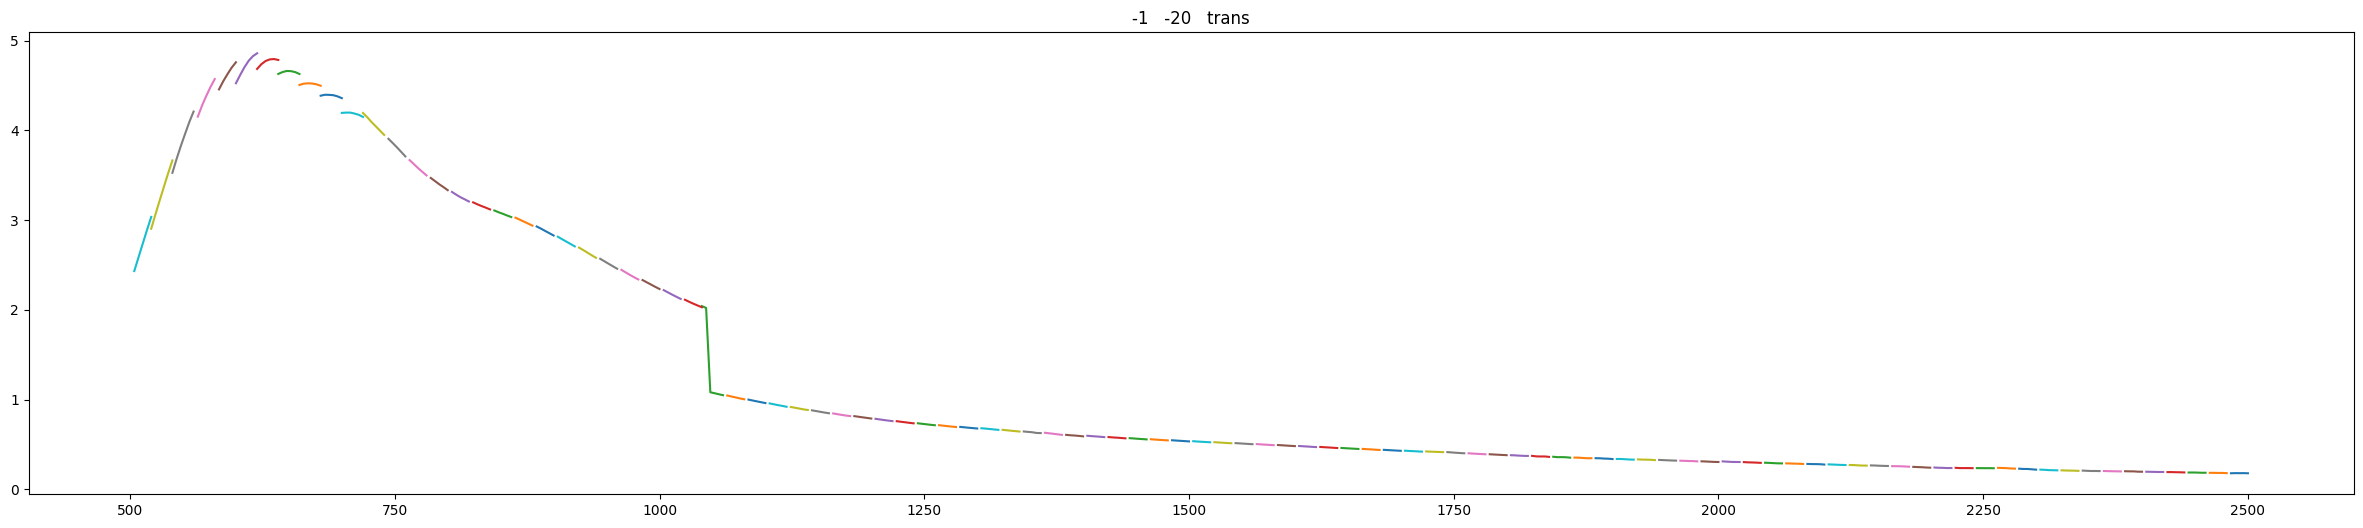

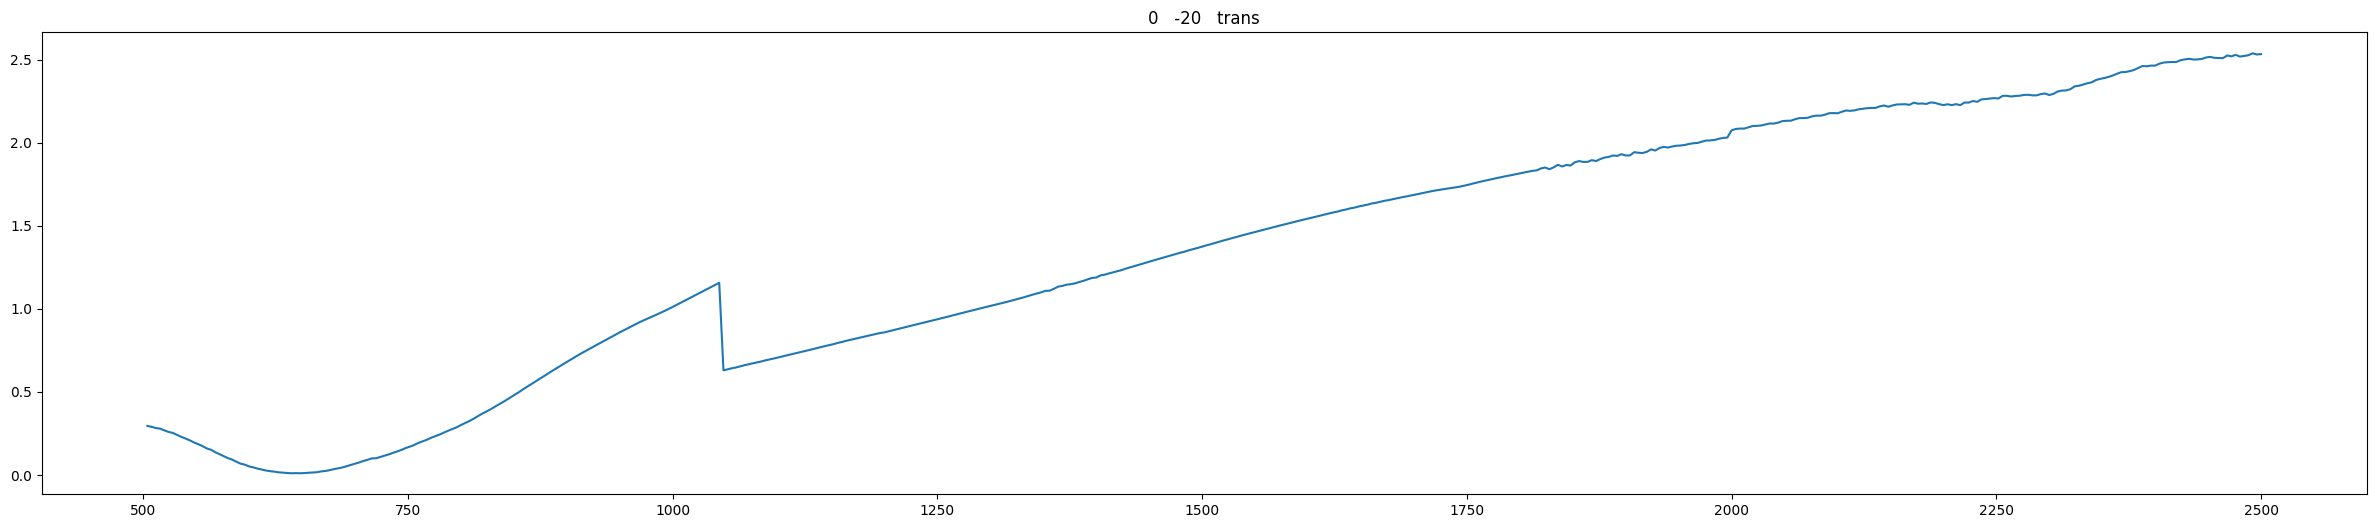

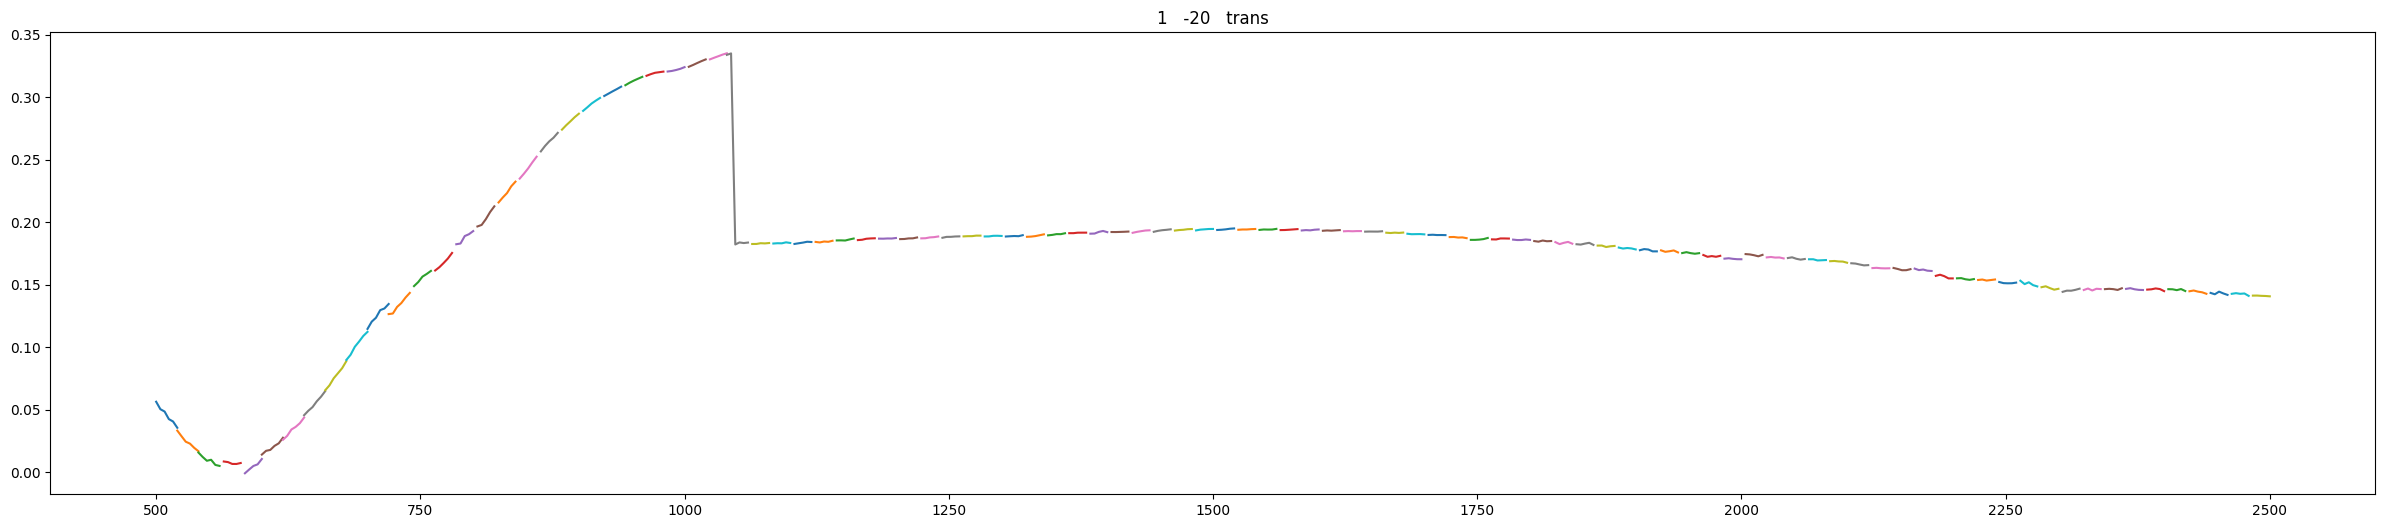

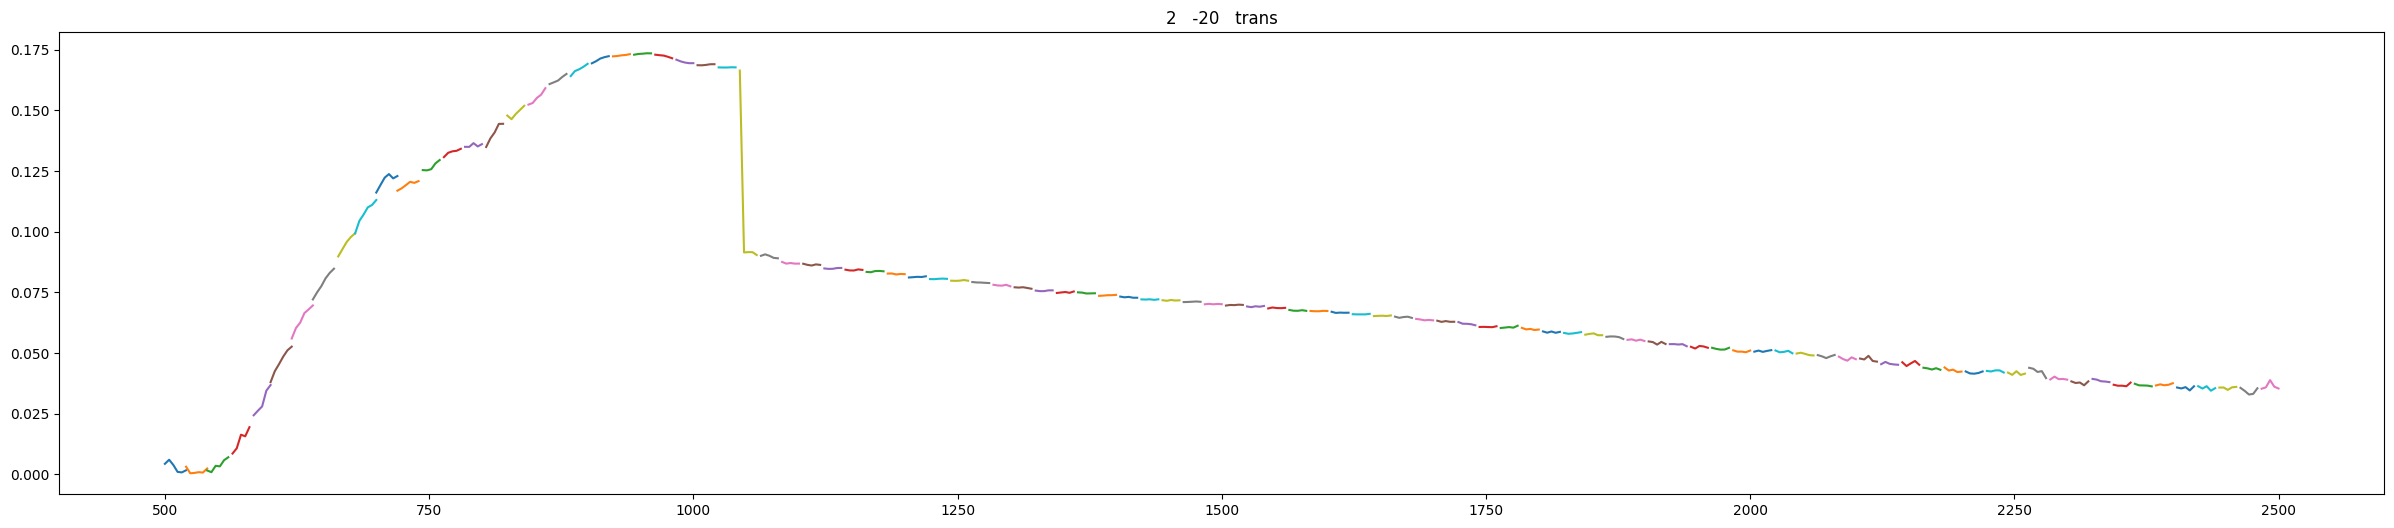

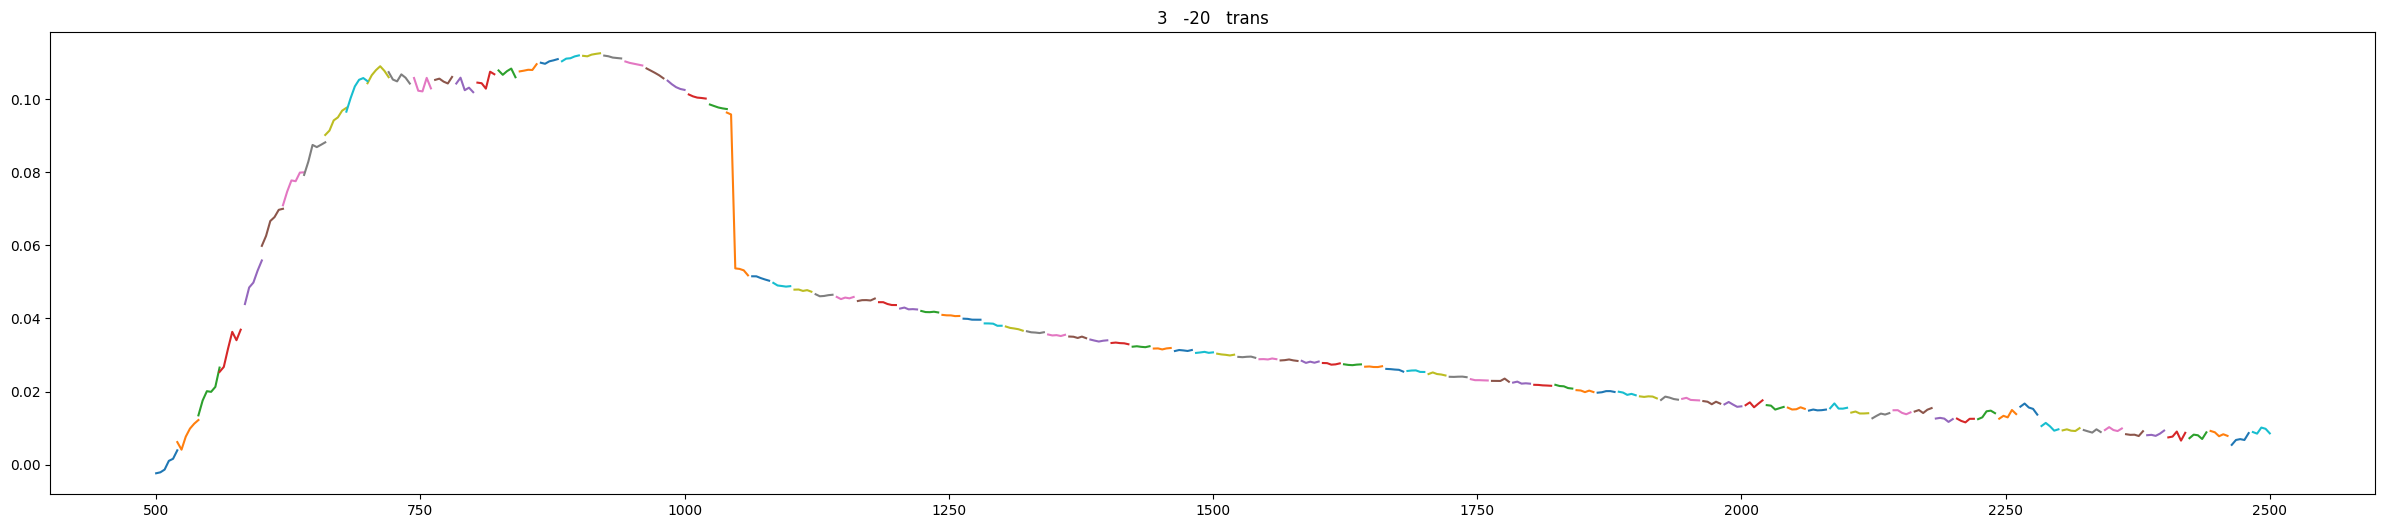

In [5]:
my_processor.show_diffraction(incident_angles = [-20], mode = ['trans'])